In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [2]:
class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule, self).__init__()
        # 定义一个三层卷积
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(128, 3)

    def forward(self, X):
        # 图片先经过三层卷积，输出维度(batch_size,C_out,H,W)
        out = self.conv(X)
        # 使用平均池化层将图片的大小变为1X1
        out = F.avg_pool2d(out, 26)
        # 将张量out从shape batch 128 x 1 x 1 x 1 变成  batch 128
        out = out.squeeze()
        # 输入到全连接层将输出的维度变为3
        out = self.fc(out)
        return out


In [3]:
device = torch.device("cuda")


In [4]:
# 数据增强 镜像操作/直方图均衡化
# car 779 truck 360 bus 218
import os
import cv2 as cv

bus_path = '/home/hatcher/test/deep-learning/VehicleDataset/bus'
car_path = '/home/hatcher/test/deep-learning/VehicleDataset/car'
truck_path = '/home/hatcher/test/deep-learning/VehicleDataset/truck'
bus_pics = os.listdir(bus_path)
car_pics = os.listdir(car_path)
truck_pics = os.listdir(truck_path)
bus_list, car_list, truck_list = [], [], []

for bus_pic in bus_pics:
    img = cv.imread(bus_path+"/"+bus_pic)
    img = cv.resize(img, (32, 32))
    flip_img = cv.flip(img, 1)
    equ_img = cv.equalizeHist(cv.cvtColor(img,cv.COLOR_BGR2GRAY))
    equ_img=cv.cvtColor(equ_img,cv.COLOR_GRAY2BGR)
    img = img/255
    bus_list.append(img)
    flip_img = flip_img/255
    bus_list.append(flip_img)
    equ_img = equ_img/255
    bus_list.append(equ_img)

for car_pic in car_pics:
    img = cv.imread(car_path+"/"+car_pic)
    img = cv.resize(img, (32, 32))
    img = img/255
    car_list.append(img)

for truck_pic in truck_pics:
    img = cv.imread(truck_path+"/"+truck_pic)
    img = cv.resize(img, (32, 32))
    flip_img = cv.flip(img, 1)
    img = img/255
    truck_list.append(img)
    flip_img = flip_img/255
    truck_list.append(flip_img)

In [5]:
#此时三种车的数据以FloatTensor的形式分别存放在三个列表中
print("bus_list length:",len(bus_list))
print("car_list length:",len(car_list))
print("truck_list length:",len(truck_list))

bus_list length: 654
car_list length: 779
truck_list length: 720


In [6]:
bus_length = len(bus_list)
car_length = len(car_list)
truck_length = len(truck_list)
num_bus_train = int(len(bus_list)*0.8)
num_car_train = int(len(car_list)*0.8)
num_truck_train = int(len(truck_list)*0.8)
train_y,test_y=[],[]
for i in range(num_bus_train):
    #train_y.append([1,0,0,0,0,0,0,0,0,0])
    train_y.append([1,0,0])
for i in range(num_car_train):
    #train_y.append([0,1,0,0,0,0,0,0,0,0])
    train_y.append([0,1,0])
for i in range(num_truck_train):
    #train_y.append([0,0,1,0,0,0,0,0,0,0])
    train_y.append([0,0,1])
for i in range(num_bus_train,bus_length):
    #test_y.append([1,0,0,0,0,0,0,0,0,0])
    test_y.append([1,0,0])
for i in range(num_car_train,car_length):
    #test_y.append([0,1,0,0,0,0,0,0,0,0])
    test_y.append([0,1,0])
for i in range(num_truck_train,truck_length):
    #test_y.append([0,0,1,0,0,0,0,0,0,0])
    test_y.append([0,0,1])
train_x,test_x=[],[]
for i in range(num_bus_train):
    train_x.append(bus_list[i])
for i in range(num_car_train):
    train_x.append(car_list[i])
for i in range(num_truck_train):
    train_x.append(truck_list[i])
for i in range(num_bus_train,bus_length):
    test_x.append(bus_list[i])
for i in range(num_car_train,car_length):
    test_x.append(car_list[i])
for i in range(num_truck_train,truck_length):
    test_x.append(truck_list[i])

train_x = torch.Tensor(train_x).permute(0,3,1,2)
test_x = torch.Tensor(test_x).permute(0,3,1,2)
train_y = torch.Tensor(train_y)
test_y = torch.Tensor(test_y)


/tmp/ipykernel_71790/521938990.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_x = torch.Tensor(train_x).permute(0,3,1,2)


In [7]:
print("train_x:",train_x.size())
print("test_x:",test_x.size())
print("train_y:",train_y.size())
print("test_y:",test_y.size())

train_x: torch.Size([1722, 3, 32, 32])
test_x: torch.Size([431, 3, 32, 32])
train_y: torch.Size([1722, 3])
test_y: torch.Size([431, 3])


In [21]:
import torch.utils.data as Data
batch_size = 1# 将训练数据的特征和标签组合
train_dataset,test_dataset = Data.TensorDataset(train_x, train_y),Data.TensorDataset(test_x, test_y)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
test_iter = Data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True,num_workers=2)

In [22]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        acc_sum += (y_hat.argmax(dim=1) == y.argmax(dim=1)).sum().item()
        l = loss(net(X), y).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n


In [28]:
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    train_loss=[]
    test_loss=[]
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l=loss(y_hat,y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            train_l_sum+=l.item()
            '''print(y_hat.shape)
            print(y.shape)
            print(y_hat)
            print(y_hat.argmax(dim=1))
            print(y)
            print(y_hat.argmax(dim=1)==y)
            '''
            train_acc_sum+=(y_hat.argmax(dim=1)==y.argmax(dim=1)).sum().item()
            n+=y.shape[0]
        #test_acc,test_l = evaluate_accuracy(test_iter,net,loss)
        train_loss.append(train_l_sum/n)
        #test_loss.append(test_l)
        #print('epoch%d,loss%.4f,train acc %3f,test acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))
    return train_loss,test_loss

In [27]:
num_epochs=20
lr=0.01
loss=nn.BCEWithLogitsLoss()

In [25]:
net = ConvModule()
net.to(device)
optimizer=torch.optim.SGD(net.parameters(),lr)
for params in net.parameters():
    nn.init.normal_(params,mean=0,std=0.01)

In [193]:
a = torch.tensor([[0.0258,-0.0033,0.0216],[0.0258,-0.0033,0.0216]])
a.argmax(dim=1)

tensor([[ 0.0258, -0.0033,  0.0216],
        [ 0.0258, -0.0033,  0.0216]])

In [29]:
train_loss,test_loss=train(net,train_iter,test_iter,loss,num_epochs,batch_size,net.parameters(),lr,optimizer)

ValueError: Target size (torch.Size([1, 3])) must be the same as input size (torch.Size([3]))

In [14]:
train_loss

[0.026492059637514418,
 0.02268125965724008,
 0.02231574245446235,
 0.02227557198718865,
 0.02228461068370201,
 0.02228047055788295,
 0.02228859461558405,
 0.022279786921682813,
 0.022275623120151192,
 0.022272032225865795,
 0.02227943558483866,
 0.022260049901011374,
 0.02225675252152652,
 0.022246326121926722,
 0.02223380930228516,
 0.02221969521142603,
 0.02218720838687146,
 0.02214768485671275,
 0.022087695178739146,
 0.02200762832344755]

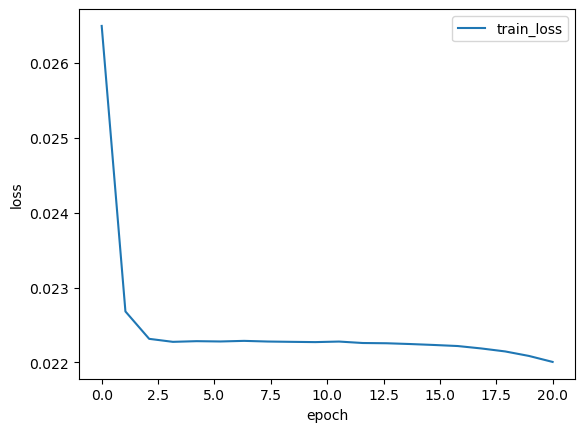

In [15]:
import matplotlib.pyplot as plt
import numpy as np
x=np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label='train_loss',linewidth=1.5)
#plt.plot(x,test_loss,label='test_loss',linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()